In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from imblearn.over_sampling import ADASYN

In [66]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [67]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [68]:
santander_train = pd.read_csv('../data/santander-customer-satisfaction/train.csv')

In [69]:
santander_train.drop(['ID'], axis=1, inplace=True)
y_target=santander_train.pop('TARGET')
X_features=santander_train.copy()

In [73]:
quant = QuantileTransformer(output_distribution='normal', random_state=72)
X_quant = quant.fit_transform(X_over)
X_quant = pd.DataFrame(X_quant, columns=X_features.columns)

In [74]:
X_quant.shape, y_target.shape

((144745, 369), (76020,))

In [ ]:
X_quant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144745 entries, 0 to 144744
Columns: 369 entries, var3 to var38
dtypes: float64(369)
memory usage: 407.5 MB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_quant, y_target, test_size=0.3, random_state=72)

ValueError: Found input variables with inconsistent numbers of samples: [144745, 76020]

In [ ]:
lgbm_lf = LGBMClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, early_stopping_rounds=100, eval_metric='auc', random_state=72, min_child_weight=1, colsample_bytree=0.5, reg_alpha=0.01, reg_lambda=0.1)

In [ ]:
xgb_lf = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, eval_metric='auc', early_stopping_rounds=100 , random_state=72, min_child_weight=1, colsample_bytree=0.5, reg_alpha=0.01, reg_lambda=0.1)

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=72)

In [ ]:
evals = [(X_val, y_val)]

In [ ]:
xgb_lf.fit(X_tr, y_tr, eval_set=evals)
lgbm_lf.fit(X_tr, y_tr, eval_set=evals)

[0]	validation_0-auc:0.70145
[1]	validation_0-auc:0.78391
[2]	validation_0-auc:0.77557
[3]	validation_0-auc:0.77690
[4]	validation_0-auc:0.79072
[5]	validation_0-auc:0.78830
[6]	validation_0-auc:0.79509
[7]	validation_0-auc:0.79488
[8]	validation_0-auc:0.80083
[9]	validation_0-auc:0.80552
[10]	validation_0-auc:0.80348
[11]	validation_0-auc:0.80934
[12]	validation_0-auc:0.80745
[13]	validation_0-auc:0.81093
[14]	validation_0-auc:0.81390
[15]	validation_0-auc:0.81587
[16]	validation_0-auc:0.81526
[17]	validation_0-auc:0.81627
[18]	validation_0-auc:0.81596
[19]	validation_0-auc:0.81754
[20]	validation_0-auc:0.81817
[21]	validation_0-auc:0.81893
[22]	validation_0-auc:0.81965
[23]	validation_0-auc:0.82090
[24]	validation_0-auc:0.82078
[25]	validation_0-auc:0.82180
[26]	validation_0-auc:0.82188
[27]	validation_0-auc:0.82227
[28]	validation_0-auc:0.82257
[29]	validation_0-auc:0.82264
[30]	validation_0-auc:0.82205
[31]	validation_0-auc:0.82145
[32]	validation_0-auc:0.82115
[33]	validation_0-au

LGBMClassifier(colsample_bytree=0.5, early_stopping_rounds=100,
               eval_metric='auc', max_depth=5, min_child_weight=1,
               n_estimators=1000, random_state=72, reg_alpha=0.01,
               reg_lambda=0.1)

In [ ]:
test_df = pd.read_csv('../data/santander-customer-satisfaction/test.csv')

In [ ]:
test_df.drop(['ID'], axis=1, inplace=True)
test_df['var3'].replace(-999999,2, inplace=True)
test_df_quant = quant.transform(test_df)

In [ ]:
xgb_pred = xgb_lf.predict_proba(test_df_quant)[:,1]
lgbm_pred = lgbm_lf.predict_proba(test_df_quant)[:,1]

[LightGBM] [Warning] Unknown parameter: eval_metric


In [ ]:
roc_auc_score(y_test, xgb_lf.predict_proba(X_test)[:,1]), roc_auc_score(y_test, lgbm_lf.predict_proba(X_test)[:,1])

[LightGBM] [Warning] Unknown parameter: eval_metric


(np.float64(0.8442405187986826), np.float64(0.8445034548991306))

In [ ]:
test_df['TARGET'] = xgb_pred

In [ ]:
test_df['TARGET'].value_counts()

TARGET
0.019507    759
0.014603    598
0.014877    329
0.178387    255
0.002174    252
           ... 
0.011021      1
0.001319      1
0.001922      1
0.315134      1
0.012420      1
Name: count, Length: 46290, dtype: int64

In [ ]:
test_df['ID'] = pd.read_csv('../data/santander-customer-satisfaction/test.csv')['ID']
test_df[['ID', 'TARGET']].to_csv('../data/santander-customer-satisfaction/submission.csv', index=False)

---
## 하이퍼 파라미터 튜닝

---

<Axes: ylabel='None'>

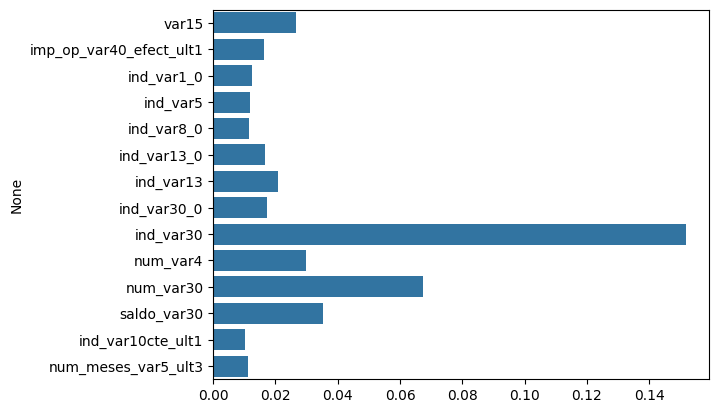

In [ ]:
# 중요도가 높은 피쳐시각화
xgb_lf.feature_importances_
sns.barplot(x=xgb_lf.feature_importances_, y=X_train.columns, order= X_train.columns[xgb_lf.feature_importances_ > 0.01], orient='h')

In [ ]:
# 중요도 상위 20개 피쳐 추출
X_features_imp = X_train.columns[np.argsort(xgb_lf.feature_importances_)[::-1]][:20]
X_imp_data = X_train[X_features_imp]


In [ ]:
X_tr_imp, X_val_imp, y_tr_imp, y_val_imp = train_test_split(X_imp_data, y_train, test_size=0.2, random_state=72)

In [ ]:
xgb_imp = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, eval_metric='auc', early_stopping_rounds=100 , random_state=72, min_child_weight=1, colsample_bytree=0.5, reg_alpha=0.01, reg_lambda=0.1)

In [ ]:
evals = [(X_val_imp, y_val_imp)]

In [ ]:
xgb_imp.fit(X_tr_imp, y_tr_imp, eval_set=evals)

[0]	validation_0-auc:0.77863
[1]	validation_0-auc:0.79990
[2]	validation_0-auc:0.80321
[3]	validation_0-auc:0.79986
[4]	validation_0-auc:0.79713
[5]	validation_0-auc:0.79232
[6]	validation_0-auc:0.79979
[7]	validation_0-auc:0.80217
[8]	validation_0-auc:0.80409
[9]	validation_0-auc:0.80265
[10]	validation_0-auc:0.80715
[11]	validation_0-auc:0.80861
[12]	validation_0-auc:0.80674
[13]	validation_0-auc:0.80427
[14]	validation_0-auc:0.80736
[15]	validation_0-auc:0.80653
[16]	validation_0-auc:0.80944
[17]	validation_0-auc:0.81005
[18]	validation_0-auc:0.81245
[19]	validation_0-auc:0.81341
[20]	validation_0-auc:0.81462
[21]	validation_0-auc:0.81339
[22]	validation_0-auc:0.81415
[23]	validation_0-auc:0.81403
[24]	validation_0-auc:0.81383
[25]	validation_0-auc:0.81435
[26]	validation_0-auc:0.81606
[27]	validation_0-auc:0.81634
[28]	validation_0-auc:0.81609
[29]	validation_0-auc:0.81645
[30]	validation_0-auc:0.81645
[31]	validation_0-auc:0.81622
[32]	validation_0-auc:0.81562
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=72, ...)

In [ ]:
print(X_features_imp)

Index(['ind_var30', 'num_var30', 'saldo_var30', 'num_var4', 'var15',
       'ind_var13', 'ind_var30_0', 'ind_var13_0', 'imp_op_var40_efect_ult1',
       'ind_var1_0', 'ind_var5', 'ind_var8_0', 'num_meses_var5_ult3',
       'ind_var10cte_ult1', 'num_var13_0', 'num_var30_0', 'num_var8_0',
       'saldo_medio_var5_ult3', 'imp_op_var39_efect_ult3',
       'num_med_var22_ult3'],
      dtype='object')


In [ ]:
imp_list = ['ind_var30', 'num_var30', 'saldo_var30', 'num_var4', 'var15',
       'ind_var13', 'ind_var30_0', 'ind_var13_0', 'imp_op_var40_efect_ult1',
       'ind_var1_0', 'ind_var5', 'ind_var8_0', 'num_meses_var5_ult3',
       'ind_var10cte_ult1', 'num_var13_0', 'num_var30_0', 'num_var8_0',
       'saldo_medio_var5_ult3', 'imp_op_var39_efect_ult3',
       'num_med_var22_ult3']

In [ ]:
test_df = pd.DataFrame(test_df_quant, columns=X_features.columns)

In [ ]:
test_df_imp = test_df[imp_list]

In [ ]:
test_df_imp.head()

,ind_var30,num_var30,saldo_var30,num_var4,var15,ind_var13,ind_var30_0,ind_var13_0,imp_op_var40_efect_ult1,ind_var1_0,ind_var5,ind_var8_0,num_meses_var5_ult3,ind_var10cte_ult1,num_var13_0,num_var30_0,num_var8_0,saldo_medio_var5_ult3,imp_op_var39_efect_ult3,num_med_var22_ult3
0,5.199338,0.275694,0.070314,0.021329,0.275694,-5.199338,5.199338,-5.199338,-5.199338,-5.199338,5.199338,-5.199338,5.199338,-5.199338,-5.199338,-0.114415,-5.199338,0.189091,-5.199338,-5.199338
1,5.199338,0.275694,-0.251016,0.021329,0.426601,-5.199338,5.199338,-5.199338,-5.199338,-5.199338,5.199338,-5.199338,5.199338,-5.199338,-5.199338,-0.114415,-5.199338,0.072829,-5.199338,-5.199338
2,5.199338,0.275694,0.230353,0.985610,-1.042247,-5.199338,5.199338,-5.199338,-5.199338,-5.199338,5.199338,-5.199338,5.199338,-5.199338,-5.199338,-0.114415,-5.199338,0.526817,1.236652,-5.199338
3,-5.199338,-5.199338,-1.088723,-5.199338,-0.459820,-5.199338,5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-0.114415,-5.199338,-0.975466,-5.199338,-5.199338
4,5.199338,0.275694,0.230353,0.021329,-1.042247,-5.199338,5.199338,-5.199338,-5.199338,-5.199338,5.199338,-5.199338,5.199338,-5.199338,-5.199338,-0.114415,-5.199338,0.317030,-5.199338,-5.199338


In [ ]:
xgb_imp.predict(test_df_imp)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
test_df_imp['TARGET'] = xgb_imp.predict(test_df_imp)

In [ ]:
test_df_imp['TARGET'].value_counts()

TARGET
0    75808
1       10
Name: count, dtype: int64

In [ ]:
test_df_imp['ID'] = pd.read_csv('../data/santander-customer-satisfaction/test.csv')['ID']

In [ ]:
test_df_imp[['ID', 'TARGET']].to_csv('../data/santander-customer-satisfaction/submission__imp.csv', index=False)